# Data exploration

* Split the data into a train and test set
* Inspect the data and discard columns that are not informative
* Visualize bike counts and weather data
* Add features that will be useful for modelling
* Visualize relationships between features and bike counts
* Save the train and test set

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
import holidays
%matplotlib inline

## Prepare a train and test set

In [2]:
# load the data into a pandas dataframe
bikes = pd.read_csv('raw.csv',index_col='Date',parse_dates=True)
bikes.head()

,Burrard_at_Cornwall,wx_longitude_x,wx_latitude_y,wx_station_name,wx_climate_id,year,month,day,wx_data_quality,wx_max_temp_c,...,wx_total_snow_cm,wx_total_snow_flag,wx_total_precip_mm,wx_total_precip_flag,wx_snow_on_grnd_cm,wx_snow_on_grnd_flag,wx_dir_of_max_gust_10s_deg,wx_dir_of_max_gust_flag,wx_spd_of_max_gust_kmh,wx_spd_of_max_gust_flag
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-01,8583.75,-123.18,49.19,VANCOUVER INTL A,1108395,2018,8,1,NaN,22.2,...,0.0,NaN,0.0,NaN,NaN,NaN,10.0,NaN,37,NaN
2018-08-02,6882.71,-123.18,49.19,VANCOUVER INTL A,1108395,2018,8,2,NaN,22.5,...,0.0,NaN,0.0,NaN,NaN,NaN,14.0,NaN,37,NaN
2018-08-03,5504.33,-123.18,49.19,VANCOUVER INTL A,1108395,2018,8,3,NaN,23.3,...,0.0,NaN,0.0,NaN,NaN,NaN,19.0,NaN,41,NaN
2018-08-04,7212.95,-123.18,49.19,VANCOUVER INTL A,1108395,2018,8,4,NaN,22.5,...,0.0,NaN,0.0,NaN,NaN,NaN,20.0,NaN,32,NaN
2018-08-05,6938.71,-123.18,49.19,VANCOUVER INTL A,1108395,2018,8,5,NaN,25.4,...,0.0,NaN,0.0,NaN,NaN,NaN,22.0,NaN,30,NaN


Before splitting the data, I need to take into account a few things. First, the data start on August 1st 2018, so I don't have a lot of data. Second, the data likely show a seasonal pattern. Third, the current bike counts might be changed by the COVID-19 pandemic. This [CBC news article](https://www.cbc.ca/news/canada/british-columbia/covid-19-bc-timeline-1.5520943) contains a timeline of key events related to the pandemic in BC. Physical distancing measures were introduced on March 16, 2020. This is when many people started to work from home.

To deal with these issues, I'll use the 2019 data (one full year) as our training data, and make predictions for January, February, and the first half of March 2020 (pre-COVID). 

In [3]:
# select the data
bikes_subset = bikes.loc['2019-01-01':'2020-03-15',].copy()

# remove rows with missing target
bikes_subset.dropna(subset=['Burrard_at_Cornwall'], inplace=True)

### Split the data into a training and test set

In [4]:
# split
train_full = bikes_subset.loc['2019-01-01':'2019-12-31',].copy()
test_full = bikes_subset.loc['2020-01-01':'2020-03-15',].copy()
train_size = len(train_full)

### Take a look at the structure of the training set

In [5]:
# get columns with numerical and categorical variables
num_cols = [colname for colname in train_full.columns if
            train_full[colname].dtype in ['int64', 'float64']]
cat_cols = [colname for colname in train_full.columns if 
            train_full[colname].dtype=='object']

In [6]:
# look at the descriptive statistics for the numerical variables
train_full[num_cols].describe()

,Burrard_at_Cornwall,wx_longitude_x,wx_latitude_y,wx_climate_id,year,month,day,wx_data_quality,wx_max_temp_c,wx_min_temp_c,wx_mean_temp_c,wx_heat_deg_days_c,wx_cool_deg_days_c,wx_total_rain_mm,wx_total_snow_cm,wx_total_precip_mm,wx_snow_on_grnd_cm,wx_dir_of_max_gust_10s_deg
count,365.000000,3.650000e+02,3.650000e+02,365.0,365.0,365.000000,365.000000,0.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,12.000000,209.000000
mean,3812.615068,-1.231800e+02,4.919000e+01,1108395.0,2019.0,6.526027,15.720548,NaN,14.141370,6.630685,10.409315,7.770411,0.179726,2.559178,0.088219,2.645753,6.416667,19.555024
std,2068.242864,2.419161e-13,3.557590e-14,0.0,0.0,3.452584,8.808321,NaN,6.697376,6.094376,6.230730,5.975035,0.565855,5.844111,0.756073,5.849393,6.156421,8.088340
min,207.410000,-1.231800e+02,4.919000e+01,1108395.0,2019.0,1.000000,1.000000,NaN,-1.500000,-8.800000,-5.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,2109.520000,-1.231800e+02,4.919000e+01,1108395.0,2019.0,4.000000,8.000000,NaN,8.600000,2.200000,5.600000,1.700000,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000
50%,3574.710000,-1.231800e+02,4.919000e+01,1108395.0,2019.0,7.000000,16.000000,NaN,13.500000,6.900000,9.800000,8.200000,0.000000,0.000000,0.000000,0.000000,4.500000,20.000000
75%,5545.390000,-1.231800e+02,4.919000e+01,1108395.0,2019.0,10.000000,23.000000,NaN,20.000000,12.100000,16.300000,12.400000,0.000000,2.400000,0.000000,2.800000,9.250000,28.000000
max,8257.960000,-1.231800e+02,4.919000e+01,1108395.0,2019.0,12.000000,31.000000,NaN,29.900000,17.400000,22.100000,23.200000,4.100000,54.800000,10.000000,54.800000,20.000000,33.000000


A few observations:
* The following variables have no missing values: longitude, latitude, climate id, year, month, day, total rain, total snow, total precip.
* The variables longitude, latitude and climate id are identical for each row, so they won't provide any information to the model.
* The variable data quality has a count of zero so won't provide any information either. 
* The variable snow_on_grnd only has 12 valid values. This likely means that there was no snow on the ground on all other days, so I will replace the missing values by zeros.

In [7]:
# look at some descriptive statistics for the categorical variables
train_full[cat_cols].describe()

,wx_station_name,wx_max_temp_flag,wx_min_temp_flag,wx_mean_temp_flag,wx_heat_deg_days_flag,wx_cool_deg_days_flag,wx_total_rain_flag,wx_total_snow_flag,wx_total_precip_flag,wx_snow_on_grnd_flag,wx_dir_of_max_gust_flag,wx_spd_of_max_gust_kmh,wx_spd_of_max_gust_flag
count,365,0.0,0.0,0.0,0.0,0.0,16,9,17,3,117,209,156
unique,1,0.0,0.0,0.0,0.0,0.0,1,1,1,2,1,22,1
top,VANCOUVER INTL A,NaN,NaN,NaN,NaN,NaN,T,T,T,E,M,32.0,M
freq,365,NaN,NaN,NaN,NaN,NaN,16,9,17,2,117,36,156


The categorical data seem to provide little information. There are a lot of missing data. For valid data, the most common values are 'T' for 'Trace' (of precipitation), 'E' for 'Estimated, and 'M' for 'Missing'. The max gust variables are incomplete. 

### Discard columns that are not informative

In [8]:
# select numerical columns with non-identical values (i.e., standard deviation>0)
# remove the column with heat_deg_days and cool_deg_days because these are calculated from the mean temperature
# remove the column with wind direction because it's incomplete and I don't expect this to influence total bike counts
num_cols = [colname for colname in num_cols if
            train_full[colname].std() > 0.001 and not
            'heat' in train_full[colname].name and not
            'cool' in train_full[colname].name and not
            'dir' in train_full[colname].name]
print(num_cols)

['Burrard_at_Cornwall', 'month', 'day', 'wx_max_temp_c', 'wx_min_temp_c', 'wx_mean_temp_c', 'wx_total_rain_mm', 'wx_total_snow_cm', 'wx_total_precip_mm', 'wx_snow_on_grnd_cm']


In [9]:
# for snow on the ground, replace missing values (there are many) by zeros
train_full['wx_snow_on_grnd_cm'].fillna(0, inplace=True)

In [10]:
# keep selected numerical columns and discard categorical columns
train = train_full[num_cols].copy()
test = test_full[num_cols].copy()

In [11]:
# look at the training set
train.head()

,Burrard_at_Cornwall,month,day,wx_max_temp_c,wx_min_temp_c,wx_mean_temp_c,wx_total_rain_mm,wx_total_snow_cm,wx_total_precip_mm,wx_snow_on_grnd_cm
Date,,,,,,,,,,
2019-01-01,1144.77,1,1,5.3,0.8,3.1,0.0,0.0,0.0,0.0
2019-01-02,1394.38,1,2,5.5,2.4,4.0,3.4,0.0,3.4,0.0
2019-01-03,886.81,1,3,9.5,4.5,7.0,54.8,0.0,54.8,0.0
2019-01-04,1483.41,1,4,10.4,6.1,8.3,9.6,0.0,9.6,0.0
2019-01-05,1561.37,1,5,8.7,5.3,7.0,3.2,0.0,3.2,0.0


## Visualize the data in the training set

### Visualize bike counts

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


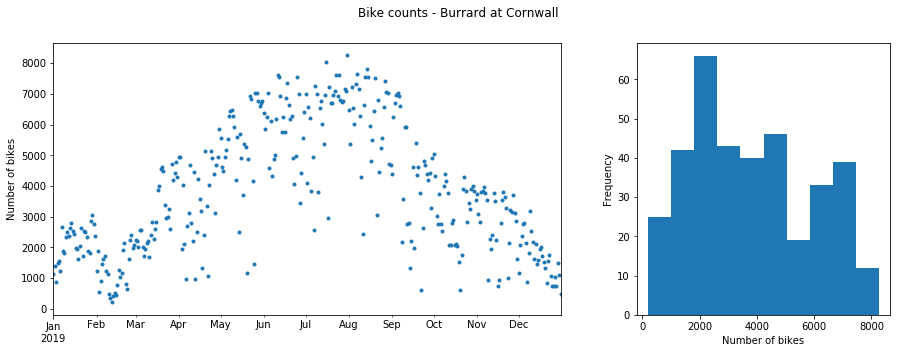

In [12]:
# visualize the target variable
fig,ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]}) 
fig.suptitle('Bike counts - Burrard at Cornwall')
# plot the bike counts over time
line = ax[0].plot(train['Burrard_at_Cornwall'], '.')
ax[0].set_ylabel('Number of bikes');
# set date ticks
ax[0].set_xlim(left=train.index[0], right=train.index[-1]);
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax[0].xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
# plot a histogram of the bike counts
hist = ax[1].hist(train['Burrard_at_Cornwall'])
ax[1].set_xlabel('Number of bikes');
ax[1].set_ylabel('Frequency');

Bike counts are lowest in winter, and highest in summer, peaking at around 8000 bikes per day.

### Visualize weather data

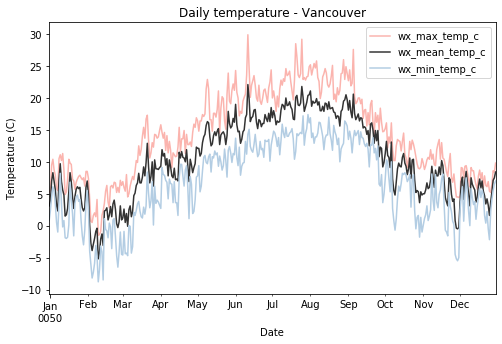

In [13]:
# select temperature data
temp = train[['wx_max_temp_c','wx_mean_temp_c','wx_min_temp_c']]

# get pastel colors for temperature plot
cmap = get_cmap("Pastel1")  
colors_pastel = cmap.colors

# plot temperature over time
colors = (colors_pastel[0], (0.2, 0.2, 0.2), colors_pastel[1])
ax = temp.plot(figsize=(8,5), color=colors)
ax.set_ylabel('Temperature (C)');
ax.set_title('Daily temperature - Vancouver');
# set date ticks
ax.set_xlim(left=train.index[0], right=train.index[-1]);
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

Unsurprisingly, the temperature also shows a seasonal pattern, with higher temperatures in summer, lower temperatures in winter, and a particularly cold spell in February.

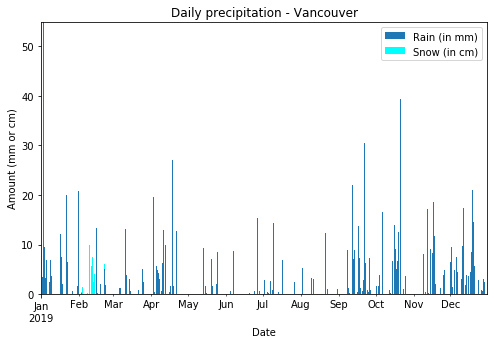

In [14]:
# plot rain and snow over time
fig,ax = plt.subplots(figsize=(8,5))
bar1 = ax.bar(train.index, train['wx_total_rain_mm'])
bar2 = ax.bar(train.index, train['wx_total_snow_cm'],
             bottom=train['wx_total_rain_mm'], color='xkcd:cyan') # stack bars
ax.legend((bar1[0], bar2[0]), ('Rain (in mm)', 'Snow (in cm)'));
ax.set_xlabel('Date');
ax.set_ylabel('Amount (mm or cm)')
ax.set_title('Daily precipitation - Vancouver')
# set date ticks
ax.set_xlim(left=train.index[0], right=train.index[-1]);
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

In [15]:
n_days_rain = sum(train['wx_total_rain_mm']>0)
n_days_snow = sum(train['wx_total_snow_cm']>0)
n_days_snow_on_grnd = sum(train['wx_snow_on_grnd_cm']>0)
print('It rained on', n_days_rain, 'days, it snowed on', n_days_snow, 'days and ' 
      'there was snow on the ground on', n_days_snow_on_grnd, 'days in Vancouver in 2019.')

It rained on 144 days, it snowed on 9 days and there was snow on the ground on 11 days in Vancouver in 2019.


### Relations between predictors (features) and bike counts

#### Correlations between weather data and bike counts

In [16]:
corr_matrix = train.corr()
corr_matrix['Burrard_at_Cornwall'].sort_values(ascending=False)

Burrard_at_Cornwall    1.000000
wx_max_temp_c          0.853049
wx_mean_temp_c         0.777936
wx_min_temp_c          0.652067
month                  0.088171
day                    0.052644
wx_total_snow_cm      -0.191478
wx_snow_on_grnd_cm    -0.217123
wx_total_rain_mm      -0.393352
wx_total_precip_mm    -0.416782
Name: Burrard_at_Cornwall, dtype: float64

The correlation with bike counts is highest with the mean, maximum, and minimum daily temperature. There is no positive correlation with the precipitation values, but this can be explained by the fact that the precipitation values are zero on most days. I will look into this below.

#### Relation between temperature and bike counts

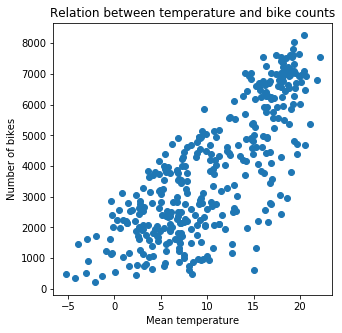

In [17]:
# create scatter plot of mean temperature and bike count
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(train['wx_mean_temp_c'], train['Burrard_at_Cornwall'])
ax.set_xlabel('Mean temperature');
ax.set_ylabel('Number of bikes')
ax.set_title('Relation between temperature and bike counts');

There is a positive and roughly linear relationship between temperature and bike counts.

#### Relation between rain and snow and bike counts
I expect lower bike counts on days with rain or snow. To examine this, I will create binary variables that indicate whether there was any rain or snow on a specific day. Since there are a lot of days without any rain or snow (even in Vancouver!), this makes more sense than looking at a linear relationship between the amount of precipitation and the bike counts.

In [18]:
# create boolean variables
# final variables will be created in the processing pipeline in the next notebook
rain_bool = np.array(train['wx_total_rain_mm']>0)
snow_bool = np.array(train['wx_total_snow_cm']>0)
snow_grnd_bool = np.array(train['wx_snow_on_grnd_cm']>0)

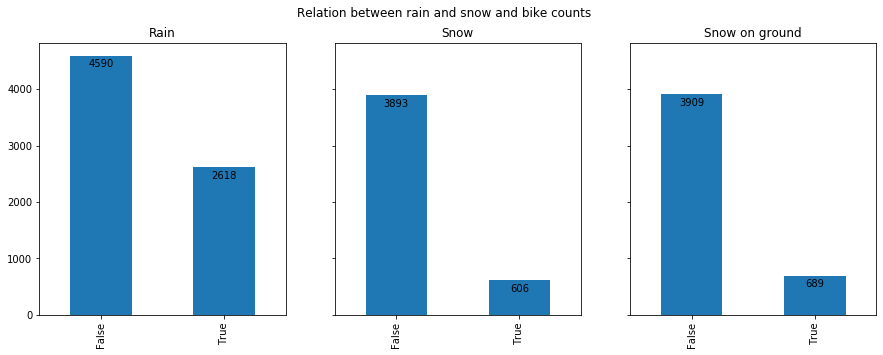

In [19]:
# get mean bike counts per condition
bikes_by_rain = train['Burrard_at_Cornwall'].groupby(rain_bool).mean()
bikes_by_snow = train['Burrard_at_Cornwall'].groupby(snow_bool).mean()
bikes_by_snow_grnd = train['Burrard_at_Cornwall'].groupby(snow_grnd_bool).mean()

# create figure
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True) 
fig.suptitle('Relation between rain and snow and bike counts')
dy_text = 200
# bar plot - rain
bikes_by_rain.plot.bar(ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_title('Rain')
ax[0].text(0, bikes_by_rain[0]-dy_text, '%d' % bikes_by_rain[0], horizontalalignment='center')
ax[0].text(1, bikes_by_rain[1]-dy_text, '%d' % bikes_by_rain[1], horizontalalignment='center') 
# bar plot - snow
bikes_by_snow.plot.bar(ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_title('Snow')
ax[1].text(0, bikes_by_snow[0]-dy_text, '%d' % bikes_by_snow[0], horizontalalignment='center')
ax[1].text(1, bikes_by_snow[1]-dy_text, '%d' % bikes_by_snow[1], horizontalalignment='center')
# bar plot - snow on ground
bikes_by_snow_grnd.plot.bar(ax=ax[2])
ax[2].set_xlabel('')
ax[2].set_title('Snow on ground')
ax[2].text(0, bikes_by_snow_grnd[0]-dy_text, '%d' % bikes_by_snow_grnd[0], horizontalalignment='center')
ax[2].text(1, bikes_by_snow_grnd[1]-dy_text, '%d' % bikes_by_snow_grnd[1], horizontalalignment='center');

The mean daily bike counts are higher when there is no rain or snow, with a large effect of rain and a very large effect of snow. These effects likely interact with the effect of temperature on bike counts.

#### Relation between day of the week and holidays and bike counts
Bike counts may also vary by day of the week, and by whether it's a statutory holiday or not. For popular commuter routes, counts may be higher on weekdays, while counts on popular recreational routes may be higher on weekends and holidays. Let's add these variables to the dataframe.

In [20]:
# add column with day of week, Monday (0) to Sunday (6)
train['day_of_week'] = train.index.dayofweek
test['day_of_week'] = test.index.dayofweek

# add column to indicate whether the day was a holiday or not
BC_holidays = holidays.Canada(prov='BC', years=[2019,2020])
train['is_holiday'] = train.index.isin(BC_holidays)
test['is_holiday'] = test.index.isin(BC_holidays)
# print holidays
for date, name in sorted(BC_holidays.items()):
    print(date, name)

2019-01-01 New Year's Day
2019-02-18 Family Day
2019-04-19 Good Friday
2019-05-20 Victoria Day
2019-07-01 Canada Day
2019-08-05 British Columbia Day
2019-09-02 Labour Day
2019-10-14 Thanksgiving
2019-11-11 Remembrance Day
2019-12-25 Christmas Day
2019-12-26 Boxing Day
2020-01-01 New Year's Day
2020-02-17 Family Day
2020-04-10 Good Friday
2020-05-18 Victoria Day
2020-07-01 Canada Day
2020-08-03 British Columbia Day
2020-09-07 Labour Day
2020-10-12 Thanksgiving
2020-11-11 Remembrance Day
2020-12-25 Christmas Day
2020-12-28 Boxing Day (Observed)


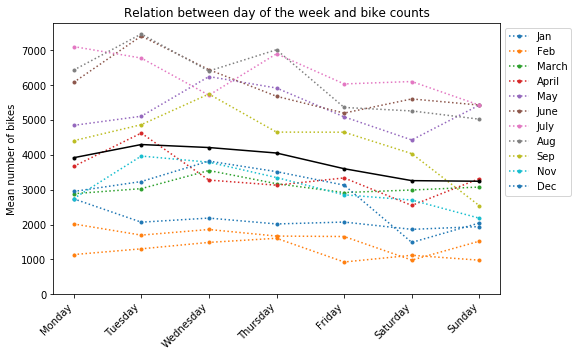

In [21]:
# get mean bike counts by day of the week and month of the year
bikes_by_dayofweek = train['Burrard_at_Cornwall'].groupby([train.index.dayofweek,train.index.month]).mean().unstack()

# create labels
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
months = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Nov','Dec']

# plot
fig,ax = plt.subplots(figsize=(8,5))  
lines = ax.plot(bikes_by_dayofweek,'.:')
line_mean = ax.plot(bikes_by_dayofweek.mean(axis=1),'k.-') # add mean across months
ax.set_xticks(np.arange(7))
ax.set_xticklabels(weekdays,rotation=45,ha='right')
ax.set_ylim(bottom=0)
ax.set_ylabel('Mean number of bikes')
ax.set_title('Relation between day of the week and bike counts');
ax.legend(lines,months,bbox_to_anchor=(1,1));

There is no clear between bike counts and days of the week, although on average the counts seem slightly higher on Fridays, Saturdays, and Sundays.

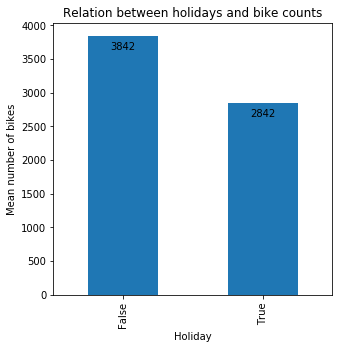

In [22]:
# get mean bike counts for holidays vs no holidays
bikes_by_holiday = train['Burrard_at_Cornwall'].groupby(train['is_holiday']).mean()

# plot
fig, ax = plt.subplots(figsize=(5,5)) 
bikes_by_holiday.plot.bar(ax=ax)
ax.set_xlabel('Holiday')
ax.set_ylabel('Mean number of bikes')
ax.set_title('Relation between holidays and bike counts');
ax.text(0, bikes_by_holiday[0]-dy_text, '%d' % bikes_by_holiday[0], horizontalalignment='center')
ax.text(1, bikes_by_holiday[1]-dy_text, '%d' % bikes_by_holiday[1], horizontalalignment='center');

The mean daily bike counts are lower on holidays.

## Save the train and test set

In [23]:
train.to_csv('train.csv')
test.to_csv('test.csv')

## What's next?

In the next notebook, I will prepare the data for modelling, and try out several models to predict bike counts.